In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from itertools import islice

In [2]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.torch.modules.loss import NegativeLogLikelihood
from gluonts.torch.distributions import NormalOutput

from estimator import ReformerEstimator

In [3]:
dataset = get_dataset("electricity")

In [4]:
dataset

TrainDatasets(metadata=MetaData(freq='1H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='321')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24), train=<gluonts.dataset.common.FileDataset object at 0x7f6a311468b0>, test=<gluonts.dataset.common.FileDataset object at 0x7f6b3486c3d0>)

In [5]:
estimator = ReformerEstimator(
    freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*7,
    
    # 
    num_feat_static_cat=1,
    cardinality=[321],
    embedding_dimension=[3],
    
    # attention hyper-params
    num_encoder_layers=2,
    num_decoder_layers=2,
    nhead=2,
    
    
    distr_output=NormalOutput(),
    loss=NegativeLogLikelihood(beta=0.5),
    
    # training params
    num_parallel_samples=10,
    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=5, accelerator='gpu', gpus=1),
)

In [6]:
predictor = estimator.train(
    training_data=dataset.train,
    num_workers=8,
    shuffle_buffer_length=1024
)

/home/kashif/.env/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/kashif/.env/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:326: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.f

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:406: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:331: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/home/kashif/gluon-ts-PR/src/gluonts

Training: 0it [00:00, ?it/s]

ValueError: Expected parameter df (Tensor of shape (128, 24)) of distribution Chi2() to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<MulBackward0>)

In [7]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, 
    predictor=predictor
)

In [8]:
forecasts = list(forecast_it)

/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:326: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:331: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:330: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluo

In [9]:
tss = list(ts_it)

In [10]:
evaluator = Evaluator()

In [11]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 2247it [00:00, 4784.80it/s]/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq i

In [12]:
agg_metrics

{'MSE': 2782145.785977615,
 'abs_error': 10299097.697694778,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.8355449737938337,
 'MAPE': 0.11845675015385011,
 'sMAPE': 0.11662507229887349,
 'MSIS': 7.367189372225982,
 'QuantileLoss[0.1]': 4826191.387874294,
 'Coverage[0.1]': 0.04863892597537457,
 'QuantileLoss[0.2]': 7324073.983684538,
 'Coverage[0.2]': 0.10445408693072243,
 'QuantileLoss[0.3]': 8925673.672461458,
 'Coverage[0.3]': 0.1902722148049251,
 'QuantileLoss[0.4]': 9855426.705049125,
 'Coverage[0.4]': 0.31087746625129803,
 'QuantileLoss[0.5]': 10299097.778426602,
 'Coverage[0.5]': 0.4599280522177719,
 'QuantileLoss[0.6]': 10253443.335411768,
 'Coverage[0.6]': 0.602321614003857,
 'QuantileLoss[0.7]': 9653788.007655425,
 'Coverage[0.7]': 0.7441588785046729,
 'QuantileLoss[0.8]': 8329638.3399652075,
 'Coverage[0.8]': 0.8544726301735648,
 'QuantileLoss[0.9]': 5876505.665932485,
 'Coverage[0.9]': 0.9270323394155

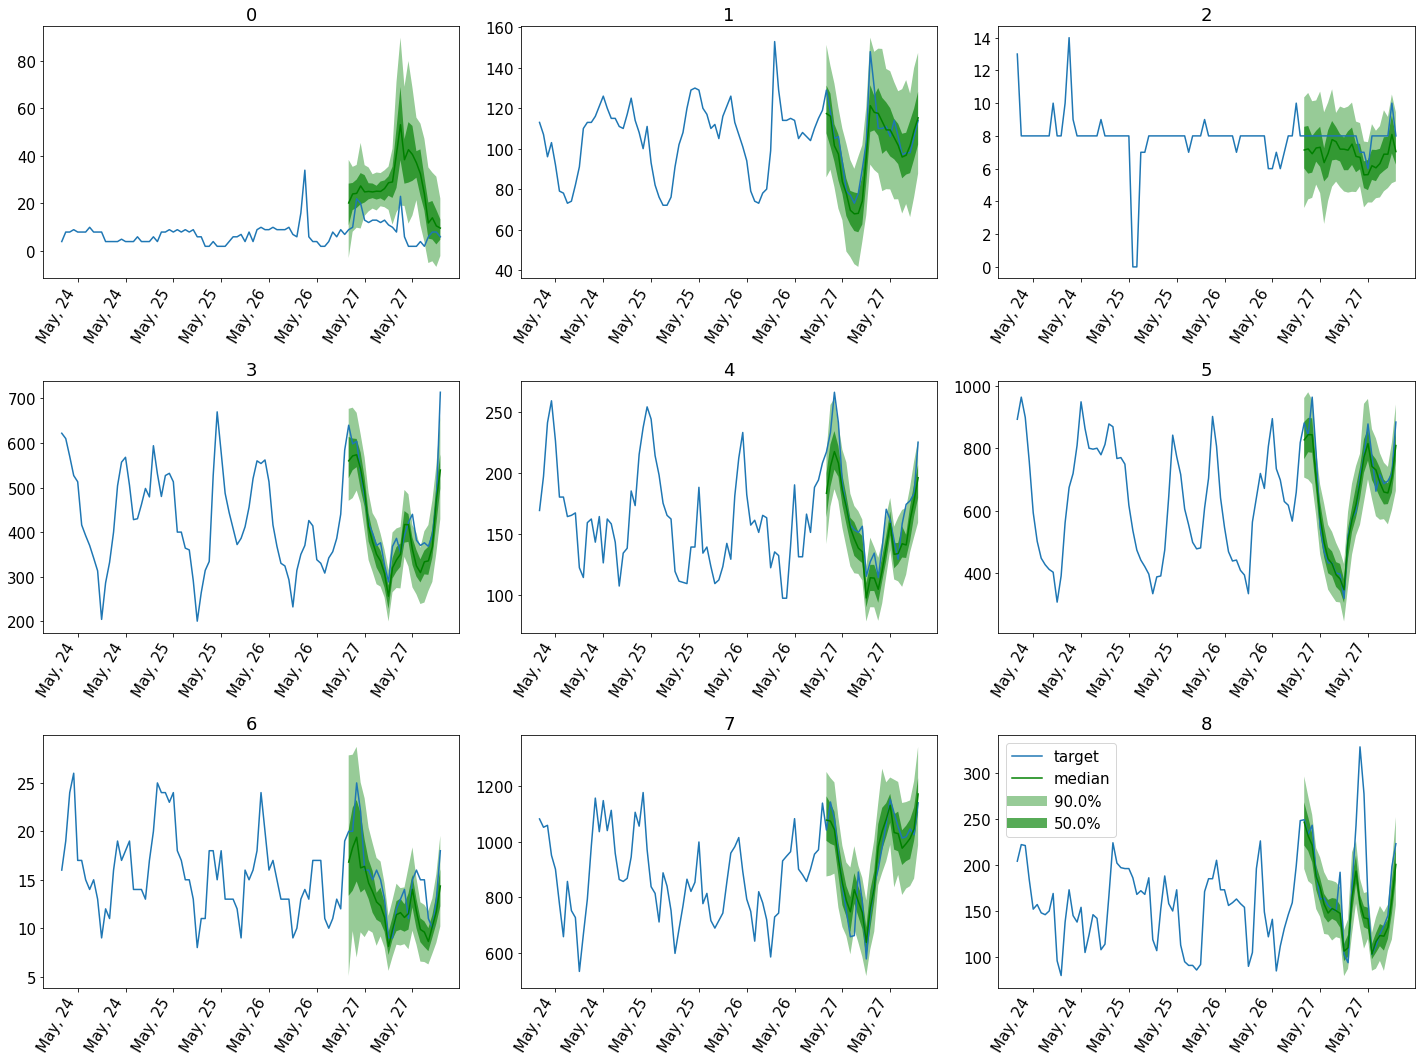

In [13]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:], label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    plt.title(forecast.item_id)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()